# Knowledge Distillation on CIFAR-10


In [1]:
# Standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# CIFAR-10 dataset
batch_size = 128
num_workers = 4 if torch.cuda.is_available() else 0

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

data_dir = './data'
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Optionally split training into train/val
val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

classes = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes
print('Classes:', classes)
print('Train batches:', len(train_loader), 'Val batches:', len(val_loader), 'Test batches:', len(test_loader))


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train batches: 352 Val batches: 40 Test batches: 79


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# Define teacher model (ResNet18) - modify final layer for CIFAR-10
def get_teacher(num_classes=10, pretrained=False):
    teacher = models.resnet18(pretrained=pretrained)
    # Adjust first conv to CIFAR size if desired (optional). We'll keep it and rely on CIFAR->224 resize if using pretrained.
    # Replace final fully connected layer:
    teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
    return teacher

teacher = get_teacher(num_classes=10, pretrained=False).to(device)
print(teacher)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# smaller student CNN
class StudentCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # 1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

student = StudentCNN(num_classes=10).to(device)
print(student)


StudentCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=10, bias=True)

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for xb, yb in pbar:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        _, predicted = preds.max(1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
        pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_loss += loss.item() * xb.size(0)
            _, predicted = preds.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    return running_loss/total, correct/total


In [6]:
# Train the teacher (or load pretrained state_dict if available)

teacher_path = './teacher_resnet18_cifar10.pth'
train_teacher = True  # set True to train teacher here

if train_teacher:
    epochs = 10
    optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(teacher, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(teacher, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        scheduler.step()
    torch.save(teacher.state_dict(), teacher_path)
else:
    if os.path.exists(teacher_path):
        teacher.load_state_dict(torch.load(teacher_path, map_location=device))
        print('Loaded teacher from', teacher_path)
    else:
        print('No saved teacher found at', teacher_path, '\nYou can set train_teacher=True to train one.')

# Quick eval of teacher
criterion = nn.CrossEntropyLoss()
val_loss, val_acc = evaluate(teacher, val_loader, criterion, device)
print('Teacher val loss:', val_loss, 'val acc:', val_acc)


Epoch 1: train_loss=2.1371, train_acc=0.2940 | val_loss=1.6108, val_acc=0.3876


Epoch 2: train_loss=1.5279, train_acc=0.4407 | val_loss=1.4639, val_acc=0.4618


Epoch 3: train_loss=1.3527, train_acc=0.5093 | val_loss=1.2745, val_acc=0.5370


Epoch 4: train_loss=1.1937, train_acc=0.5739 | val_loss=1.1963, val_acc=0.5688


Epoch 5: train_loss=1.0924, train_acc=0.6146 | val_loss=1.1007, val_acc=0.6044


Epoch 6: train_loss=1.0155, train_acc=0.6428 | val_loss=1.0472, val_acc=0.6256


Epoch 7: train_loss=0.9608, train_acc=0.6660 | val_loss=1.0176, val_acc=0.6410


Epoch 8: train_loss=0.9160, train_acc=0.6800 | val_loss=0.9927, val_acc=0.6462


Epoch 9: train_loss=0.8843, train_acc=0.6923 | val_loss=0.9554, val_acc=0.6634


Epoch 10: train_loss=0.8594, train_acc=0.7031 | val_loss=0.9677, val_acc=0.6660
Teacher val loss: 0.969309494972229 val acc: 0.6636


In [7]:
# Hinton et al., "Distilling the Knowledge in a Neural Network" (2015)
# https://arxiv.org/abs/1503.02531
# ------------------------------------------------------------
# loss = alpha * CE(student, hard_labels)
#       + (1 - alpha) * T^2 * KL(soft_student, soft_teacher)
# where:
#   soft_student = softmax(student / T)
#   soft_teacher = softmax(teacher / T)
# ============================================================

def kd_hinton_loss_fn(student_logits, teacher_logits, true_labels, temperature=4.0, alpha=0.5):
    # Cross-entropy with true labels
    ce_loss = F.cross_entropy(student_logits, true_labels)
    # Soft targets: KL divergence between softened probabilities
    p_student = F.log_softmax(student_logits / temperature, dim=1)
    p_teacher = F.softmax(teacher_logits / temperature, dim=1)
    kl_loss = F.kl_div(p_student, p_teacher, reduction='batchmean')
    loss = alpha * ce_loss + (1. - alpha) * (temperature ** 2) * kl_loss
    return loss, ce_loss, kl_loss


In [8]:
# Distillation training loop

def train_student_kd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, temperature=4.0, alpha=0.5):
    teacher.eval()
    student.train()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for xb, yb in pbar:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(xb)
            student_logits = student(xb)
            loss, ce, kl = kd_hinton_loss_fn(student_logits, teacher_logits, yb, temperature=temperature, alpha=alpha)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc = evaluate(student, val_loader, nn.CrossEntropyLoss(), device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), 'student_kd_best.pth')
    print('Best val acc:', best_val_acc)
    return history


In [9]:
# Example hook setup:
teacher_features, student_features = {}, {}

def get_activation(name, storage):
    def hook(model, input, output):
        storage[name] = output
    return hook

# Register on a specific layer
teacher.layer4.register_forward_hook(get_activation('t_feat', teacher_features))
student.features[-2].register_forward_hook(get_activation('s_feat', student_features))


Epoch 1: train_loss=1.5896, train_acc=0.4125 | val_loss=1.7607, val_acc=0.3892


Epoch 2: train_loss=1.5595, train_acc=0.4288 | val_loss=1.3672, val_acc=0.5054


Epoch 3: train_loss=1.2196, train_acc=0.5227 | val_loss=1.2305, val_acc=0.5506


Epoch 4: train_loss=1.1081, train_acc=0.5538 | val_loss=1.2280, val_acc=0.5398


Epoch 5: train_loss=1.0357, train_acc=0.5782 | val_loss=1.1547, val_acc=0.5796


Epoch 6: train_loss=0.9838, train_acc=0.5982 | val_loss=1.1147, val_acc=0.5924


Epoch 7: train_loss=0.9398, train_acc=0.6111 | val_loss=1.0572, val_acc=0.6234


Epoch 8: train_loss=0.9033, train_acc=0.6230 | val_loss=1.0636, val_acc=0.6228


Epoch 9: train_loss=0.8706, train_acc=0.6367 | val_loss=1.0057, val_acc=0.6346


Epoch 10: train_loss=0.8385, train_acc=0.6476 | val_loss=1.0166, val_acc=0.6338


Epoch 11: train_loss=0.8188, train_acc=0.6558 | val_loss=0.9745, val_acc=0.6512


Epoch 12: train_loss=0.7916, train_acc=0.6674 | val_loss=0.9487, val_acc=0.6570


Epoch 13: train_loss=0.7688, train_acc=0.6745 | val_loss=0.9242, val_acc=0.6704


Epoch 14: train_loss=0.7499, train_acc=0.6836 | val_loss=0.9466, val_acc=0.6646


Epoch 15: train_loss=0.7256, train_acc=0.6918 | val_loss=0.9210, val_acc=0.6694


Epoch 16: train_loss=0.7095, train_acc=0.6992 | val_loss=0.8786, val_acc=0.6962


Epoch 17: train_loss=0.6941, train_acc=0.7055 | val_loss=0.8767, val_acc=0.6926


Epoch 18: train_loss=0.6805, train_acc=0.7130 | val_loss=0.8494, val_acc=0.7046


Epoch 19: train_loss=0.6606, train_acc=0.7200 | val_loss=0.8371, val_acc=0.7150


Epoch 20: train_loss=0.6571, train_acc=0.7232 | val_loss=0.8135, val_acc=0.7222
Best val acc: 0.7222


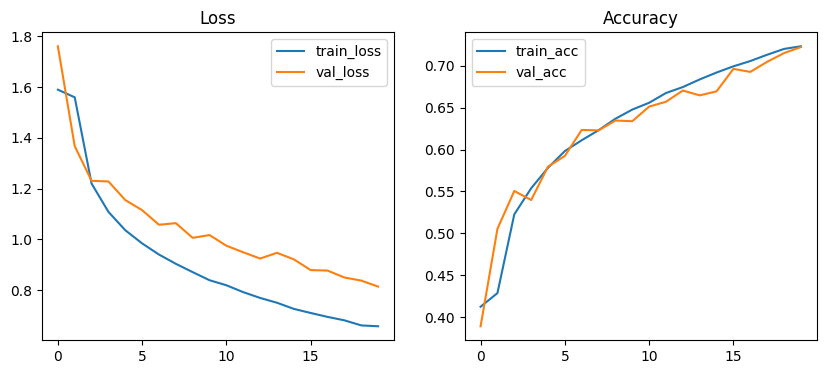

In [10]:
# Run distillation (set run_kd=True to perform training)
run_kd = True
if run_kd:
    # Optionally load a teacher checkpoint if not already loaded
    history = train_student_kd(student, teacher, train_loader, val_loader, epochs=20, lr=1e-3, temperature=4.0, alpha=0.5)
    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.legend()
    plt.title('Accuracy')
else:
    print('Set run_kd=True to train the student with knowledge distillation.')


Loaded student from student_kd_best.pth
Student test loss: 0.7686939729690552 test acc: 0.7361


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


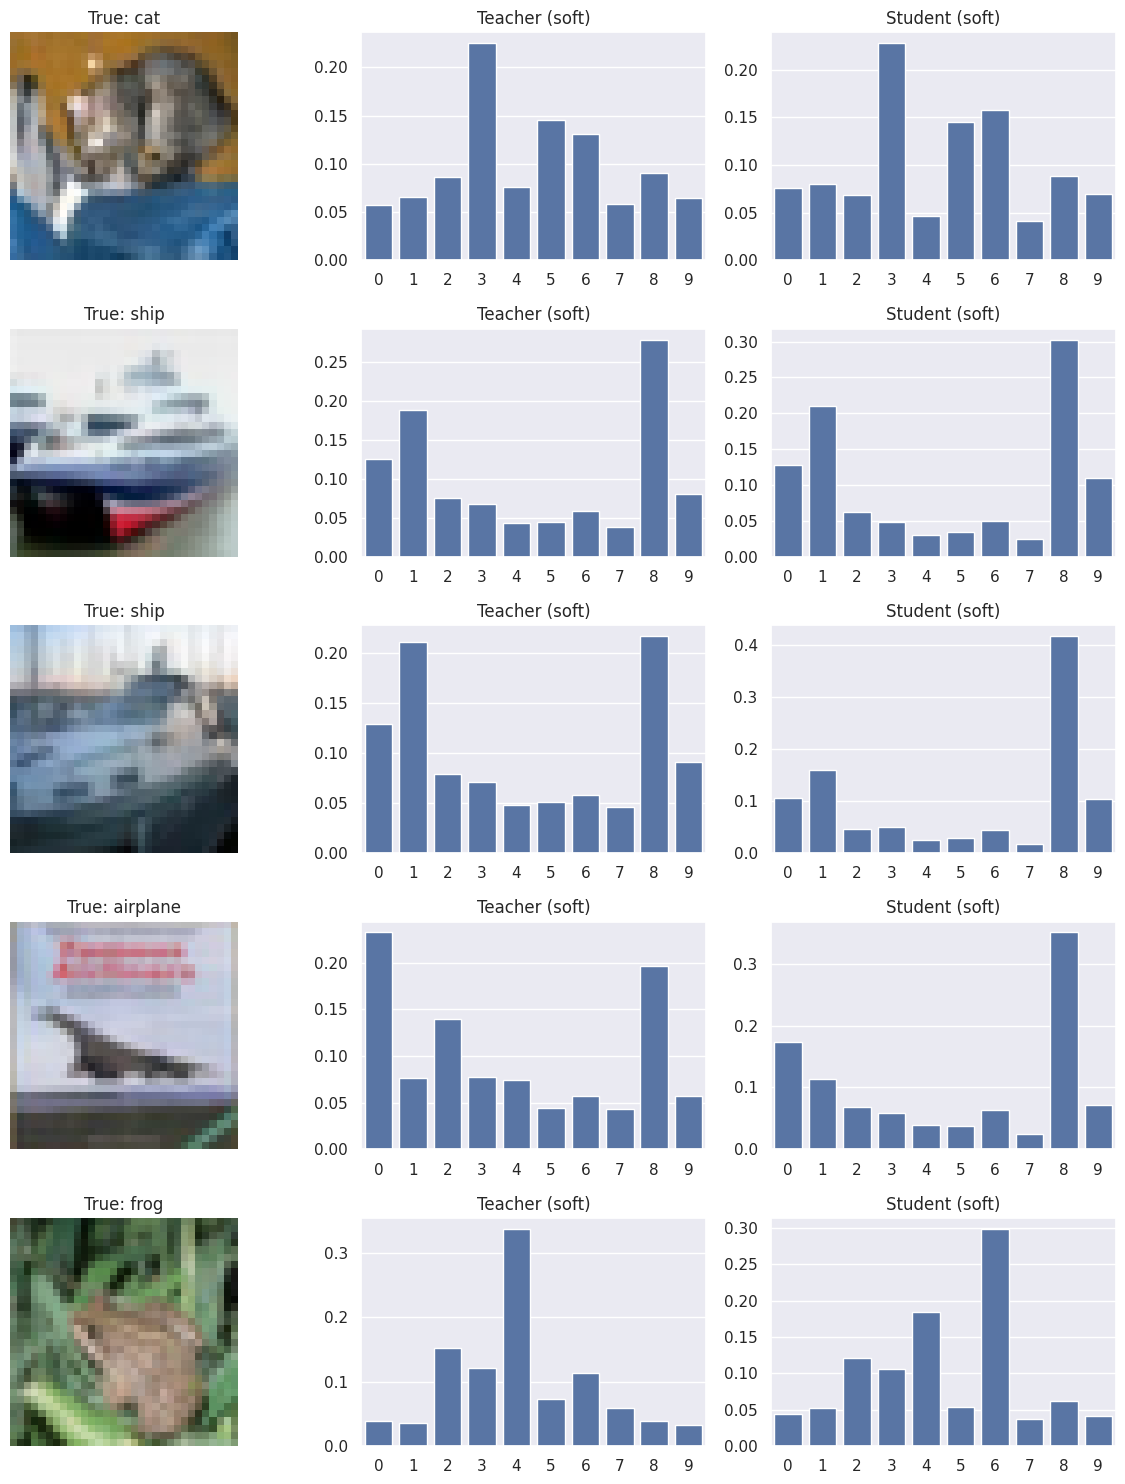

In [11]:
# Evaluate student (load best checkpoint if present)
student_path = 'student_kd_best.pth'
if os.path.exists(student_path):
    student.load_state_dict(torch.load(student_path, map_location=device))
    print('Loaded student from', student_path)
else:
    print('No student checkpoint found at', student_path)

criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(student, test_loader, criterion, device)
print('Student test loss:', test_loss, 'test acc:', test_acc)

# Visualize some predictions and teacher vs student soft logits for a few samples
import seaborn as sns
sns.set()

def visualize_logits(student, teacher, loader, n=5, temperature=4.0):
    student.eval(); teacher.eval()
    images = []
    student_probs = []
    teacher_probs = []
    labels = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            t_logits = teacher(xb)
            s_logits = student(xb)
            t_ps = F.softmax(t_logits / temperature, dim=1).cpu().numpy()
            s_ps = F.softmax(s_logits / temperature, dim=1).cpu().numpy()
            for i in range(min(n, xb.size(0))):
                images.append(xb[i].cpu())
                teacher_probs.append(t_ps[i])
                student_probs.append(s_ps[i])
                labels.append(yb[i].cpu().item())
            break
    # Plot images + barplots
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        ax = plt.subplot(n, 3, i*3 + 1)
        img = images[i]
        # unnormalize
        img = img * torch.tensor((0.247,0.243,0.261)).view(3,1,1) + torch.tensor((0.4914,0.4822,0.4465)).view(3,1,1)
        npimg = np.clip(img.permute(1,2,0).numpy(), 0, 1)
        ax.imshow(npimg)
        ax.set_title(f'True: {classes[labels[i]]}')
        ax.axis('off')

        ax2 = plt.subplot(n, 3, i*3 + 2)
        sns.barplot(x=list(range(len(teacher_probs[i]))), y=teacher_probs[i])
        ax2.set_title('Teacher (soft)')

        ax3 = plt.subplot(n, 3, i*3 + 3)
        sns.barplot(x=list(range(len(student_probs[i]))), y=student_probs[i])
        ax3.set_title('Student (soft)')
    plt.tight_layout()

# Visualize first batch from test loader
visualize_logits(student, teacher, test_loader, n=5, temperature=4.0)


# Задание на семинар

Реализовать 3 из лоссов ниже и попробовать дистиллировать предобученную модель (можно использовать свои вариации teacher и student моделей, вместо предложенных в семинаре). Нужно привести таблицу сравнения качества 2 выбранных лоссов и классического Hinton лосса.

In [12]:
# FitNets (Romero et al., "FitNets: Hints for Thin Deep Nets", 2015)
# https://arxiv.org/abs/1412.6550
# ------------------------------------------------------------
# loss = alpha * KD_loss
#       + beta * MSE(student_feature, teacher_feature)
# ============================================================

def fitnet_loss(student_logits, teacher_logits, student_feat, teacher_feat,
                targets, T=4.0, alpha=0.5, beta=50.0):
    ce_loss = F.cross_entropy(student_logits, targets)

    p_student = F.log_softmax(student_logits / T, dim=1)
    p_teacher = F.softmax(teacher_logits / T, dim=1)
    kl_loss = F.kl_div(p_student, p_teacher, reduction='batchmean')

    kd_loss = alpha * ce_loss + (1. - alpha) * (T ** 2) * kl_loss

    mse_loss = F.mse_loss(student_feat, teacher_feat)
    total_loss = kd_loss + beta * mse_loss
    return total_loss, kd_loss, mse_loss

In [22]:
# Attention Transfer (Zagoruyko & Komodakis, 2017)
# https://arxiv.org/abs/1612.03928
# ------------------------------------------------------------
# Symbols:
#   F_t : teacher feature map  [B, C, H, W]
#   F_s : student feature map  [B, C, H, W]
#   mean_c : mean in channel dim
#
# ------------------------------------------------------------
# Full formula:
#     L_AT = || Normalize( mean_c(F_s^2) ) - Normalize( mean_c(F_t^2) ) ||_2^2
# ============================================================

def at_loss(student_feat, teacher_feat):
  s_att = student_feat.pow(2).mean(dim=1)
  t_att = teacher_feat.pow(2).mean(dim=1)
  s_att = s_att.view(s_att.size(0), -1)
  t_att = t_att.view(t_att.size(0), -1)
  s_att = F.normalize(s_att, p=2, dim=1)
  t_att = F.normalize(t_att, p=2, dim=1)
  return (s_att - t_att).pow(2).sum()

In [23]:
# Relational Knowledge Distillation (Park et al., 2019)
# https://arxiv.org/abs/1904.05068
# ------------------------------------------------------------
# loss = distance_loss + angle_loss
# where:
#   distance_loss = SmoothL1(pairwise_distance(student), pairwise_distance(teacher))
#   angle_loss    = SmoothL1(pairwise_angle(student), pairwise_angle(teacher))
# ============================================================

def rkd_loss(student_feat, teacher_feat):
    with torch.no_grad():
        t_flat = teacher_feat.view(teacher_feat.size(0), -1)
    s_flat = student_feat.view(student_feat.size(0), -1)

    t_dist = torch.cdist(t_flat, t_flat, p=2)
    s_dist = torch.cdist(s_flat, s_flat, p=2)
    t_dist = t_dist / (t_dist.mean() + 1e-8)
    s_dist = s_dist / (s_dist.mean() + 1e-8)

    loss = F.smooth_l1_loss(s_dist, t_dist)
    return loss

In [15]:
# Contrastive Representation Distillation (Tian et al., 2020)
# https://arxiv.org/abs/1910.10699
# ------------------------------------------------------------
# Symbols:
#   s_i  -> feature vector from student for sample i
#   t_i  -> corresponding feature vector from teacher for sample i
#   t_j  -> teacher features of *other* samples (negatives)
#   τ (tau) -> temperature scaling factor for softmax sharpness
#
# Formula:
#   loss = -log( exp(sim(s_i, t_i)/τ) / sum_j exp(sim(s_i, t_j)/τ) )
#
# Where:
#   sim(a, b) = cosine_similarity(a, b)
# ============================================================

def crd_loss(student_feat, teacher_feat, temperature=0.07):
    ...

In [16]:
# Decoupled Knowledge Distillation (Zhao et al., CVPR 2022)
# https://arxiv.org/abs/2203.08679
# ------------------------------------------------------------
# Symbols:
#   p_t = teacher's softmax probabilities (teacher predictions)
#   p_s = student's softmax probabilities (student predictions)
#   y_true = ground truth class index
#   p_t_pos = teacher's predicted probability for the correct class
#   p_t_neg = sum of teacher probabilities for all *other* classes
#   log_s_pos = log of student's predicted prob for correct class
#   log_s_neg = log of student's total prob for all *other* classes
#
# Formula:
#   loss_target     = - (T^2) * mean(p_t_pos * log(p_s_pos))
#   loss_non_target = - (T^2) * mean(p_t_neg * log(p_s_neg))
#   total_loss = α * loss_target + β * loss_non_target
#
# Notes:
#   - T = temperature (same concept as in classic KD)
#   - α, β = balance weights between the two parts
# ============================================================

def dkd_loss(student_logits, teacher_logits, targets, alpha=1.0, beta=8.0, T=4.0):
    ...


In [17]:
feats = {}
def get_hook(name):
    def hook(model, input, output):
        feats[name] = output
    return hook
teacher.layer1.register_forward_hook(get_hook('teacher_feat'))

In [18]:
def train_distill(mode, student, teacher, loader, epochs=10):
    optimizer = optim.Adam(student.parameters(), lr=1e-3)

    h1 = teacher.layer1.register_forward_hook(get_hook('teacher'))
    h2 = student.features.register_forward_hook(get_hook('student'))

    history = []

    for epoch in range(epochs):
        student.train()
        running_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(loader, desc=f"Mode: {mode} | Ep {epoch+1}", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                t_logits = teacher(xb)
            s_logits = student(xb)

            loss = 0
            ce_loss = F.cross_entropy(s_logits, yb)

            if mode == 'Hinton':
                T = 4.0
                alpha = 0.5
                soft_loss = F.kl_div(F.log_softmax(s_logits/T, dim=1),
                                     F.softmax(t_logits/T, dim=1),
                                     reduction='batchmean') * (T**2)
                loss = alpha * ce_loss + (1-alpha) * soft_loss

            elif mode == 'AT':
                s_feat = feats['student']
                t_feat = feats['teacher']

                at_val = at_loss(s_feat, t_feat)
                loss = ce_loss + 1000.0 * at_val

            elif mode == 'RKD':
                 s_feat = feats['student']
                 t_feat = feats['teacher']
                 s_pool = F.adaptive_avg_pool2d(s_feat, (1,1))
                 t_pool = F.adaptive_avg_pool2d(t_feat, (1,1))

                 rkd_val = rkd_loss(s_pool, t_pool)
                 loss = ce_loss + 1.0 * rkd_val

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = s_logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

        val_acc = evaluate(student, val_loader)
        history.append(val_acc)

    h1.remove()
    h2.remove()
    return history[-1]

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

In [24]:
modes = ['AT', 'RKD', 'Hinton']
results = {}

for m in modes:
    print(f"Mode == {m}")
    student_net = StudentCNN().to(device)
    final_acc = train_distill(m, student_net, teacher, train_loader, epochs=10)
    results[m] = final_acc
    print(f"Result {m}: {final_acc:.4f}")

print("\n")
print(f"{'Method':<15} | {'Val Accuracy':<15}")
print("-" * 30)
for k, v in results.items():
    print(f"{k:<15} | {v:.4f}")
print("\n")

Mode == AT


Result AT: 0.6246
Mode == RKD


Result RKD: 0.6322
Mode == Hinton


Result Hinton: 0.6240


Method          | Val Accuracy   
------------------------------
AT              | 0.6246
RKD             | 0.6322
Hinton          | 0.6240


